In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from sktime.transformations.series.boxcox import BoxCoxTransformer
from ipywidgets import interact
import ipywidgets as widgets


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# loading the data

In [17]:
def parse(x):
    return datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('./data/tourism.csv', parse_dates=['Quarter'], date_parser=parse)
df.drop(['Unnamed: 0', 'Region', 'State', 'Purpose'], axis=1, inplace=True)
df = df.groupby('Quarter').sum().reset_index().set_index('Quarter')
df.sort_index(inplace=True)
df

,Trips
Quarter,
1998-01-01,23932.544141
1998-04-01,20856.726540
1998-07-01,20222.802189
1998-10-01,21342.960517
1999-01-01,22801.711403
...,...
2015-10-01,25759.429177
2016-01-01,27492.360374
2016-04-01,24791.797758


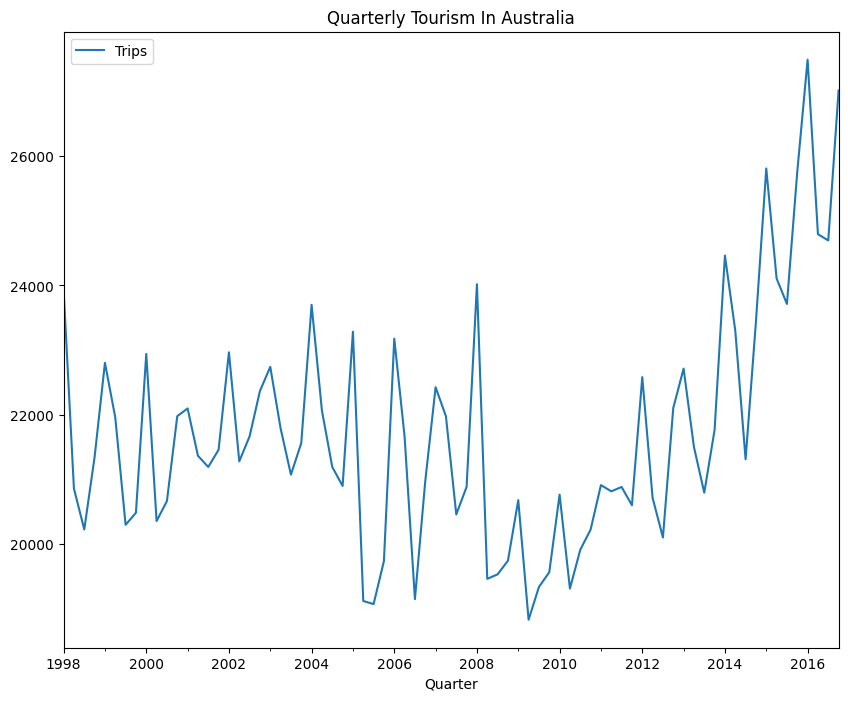

In [18]:
df.plot(title='Quarterly Tourism In Australia')
plt.legend()
plt.show()

# ploting the acf

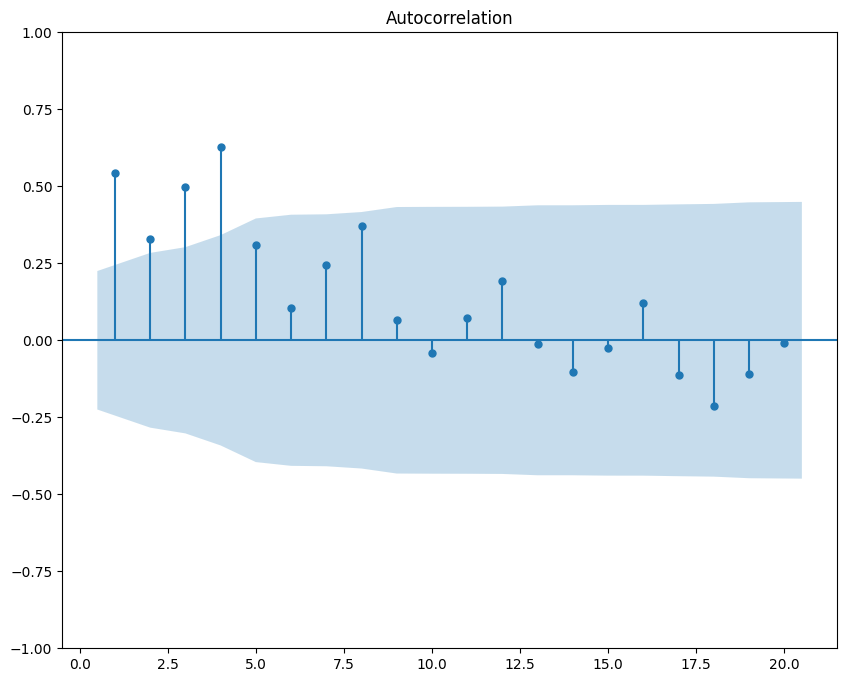

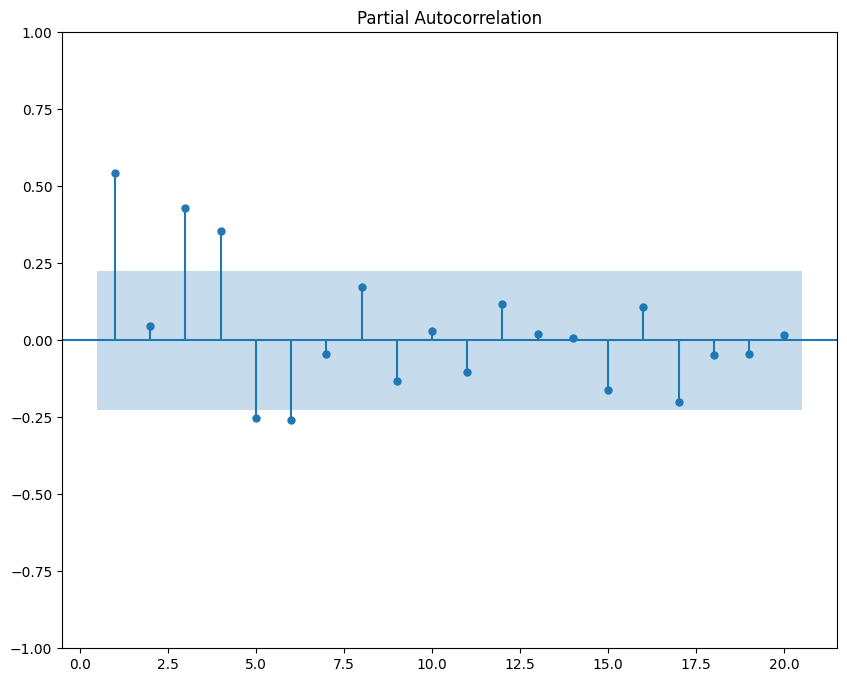

In [19]:
plot_acf(df, lags=20, zero=False)
plot_pacf(df, lags=20, zero=False)
plt.show()

# using the kpss test to test for stationarity around a deterministic trend

In [20]:
tstest = kpss(df, "ct")
tstest

(0.2915144352537406,
 0.01,
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [21]:
for i in np.arange(-30.00, 30.0, 0.01):
    transformer = BoxCoxTransformer(method="fixed", lambda_fixed=i)
    BoxCox_y_hat = transformer.fit_transform(df)
    kpss_stat, _, _, crit = kpss(BoxCox_y_hat, "ct")
    if kpss_stat <= crit["5%"]:
        plt.plot(df, label="Trips")
        plt.legend()
        plt.show()
        plt.plot(BoxCox_y_hat, label="BoxCox at lambda = " + str(i))
        plt.legend()
        plt.show()
        print(transformer.get_fitted_params())
        break

In [36]:
def plot_function(lambda_fixed):
    transformer = BoxCoxTransformer(method="fixed", lambda_fixed=lambda_fixed)
    BoxCox_y_hat = transformer.fit_transform(df)
    plt.plot(BoxCox_y_hat, label="BoxCox at lambda = " + str(lambda_fixed))
    plt.legend()
    plt.show()
    
# Create the interactive widget with a wider slider range
lambda_slider = widgets.FloatSlider(
    value=0.0,
    min=-30.0,
    max=30.0,
    step=0.0001,
    description='Lambda:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')  # Adjust the width as needed
)

# Create the interactive widget
interact(plot_function, lambda_fixed=lambda_slider)

interactive(children=(FloatSlider(value=0.0, description='Lambda:', layout=Layout(width='100%'), max=30.0, min…

<function __main__.plot_function(lambda_fixed)>

# the box cox transformation won't work so we will transform this multiplicative time series to an additive one using the log function

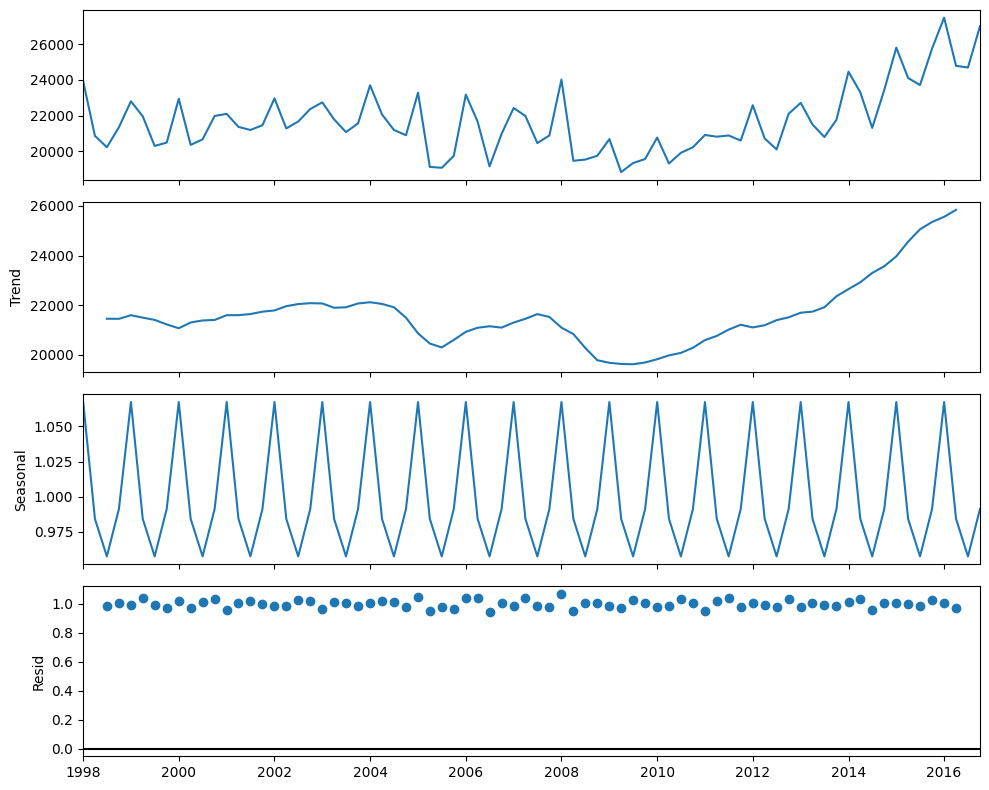

In [37]:
res = sm.tsa.seasonal_decompose(df, model="multiplicative")

resplot = res.plot()

### measuring the strength of the trend using this formula: Ft = max(0, 1 − Var(Rt) / Var(Tt + Rt))

In [38]:
trend_strength = max(0, 1 - (np.var(res.resid) / np.var(res.trend + res.resid)))
trend_strength

0.9999999996136211

### measuring the strength of the seasonality using this formula: Ft = max(0, 1 − Var(Rt) / Var(St + Rt))

In [39]:
seasonal_strength = max(0, 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid)))
seasonal_strength

0.711325685633335